In [2]:
import pandas as pd
!pip install numpy pandas
!pip install openpyxl #attribute to install excel reading
%pip install matplotlib seaborn plotly seaborn yfinance statsmodel.api
%pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from pandas import to_datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement statsmodel.api (from versions: none)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
ERROR: No matching distribution found for statsmodel.api
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:

Inflation_diff = pd.read_csv('Inflation_diff.csv')
Interest_diff = pd.read_csv('Interest_diff.csv')
Current_account_diff = pd.read_csv('Current_account_diff.csv')
swaps_df = pd.read_csv('merged_df_month_year.csv')

In [4]:
# Data Preparation
inf = Inflation_diff[['USDINR']]
int_diff = Interest_diff[['USDINR']]
curr_acc = Current_account_diff[['USDINR']]
USDINR = swaps_df[['USDINR_20Y', 'month-year', 'log_returns_USDINR_20Y']]
dates = swaps_df['month-year']

#apply pct change to currencies, and differencing to the idv
inf = inf.diff().fillna(0.0)
int_diff = int_diff.diff().fillna(0.0)
curr_acc = curr_acc.diff().fillna(0.0)

USDINR = USDINR['USDINR_20Y'].pct_change().fillna(0.0)

In [5]:
#combining factors
combined_factors = pd.concat([inf, int_diff, curr_acc], axis=1)
combined_factors.columns = ['Inflation', 'Interest_Rate_Diff', 'Current_Account_Diff']

In [6]:
#train and test split by indexing
train_size = int(len(combined_factors) * 0.8)
train_factors = combined_factors[:train_size]
test_factors = combined_factors[train_size:]
train_target = USDINR[:train_size]
test_target = USDINR[train_size:]
train_dates = dates[:train_size]
test_dates = dates[train_size:]

#realign all indices
train_factors = train_factors.align(train_target, join='inner', axis=0)[0]
test_factors = test_factors.align(test_target, join='inner', axis=0)[0]
train_target = train_target.align(train_factors, join='inner', axis=0)[0]
test_target = test_target.align(test_factors, join='inner', axis=0)[0]

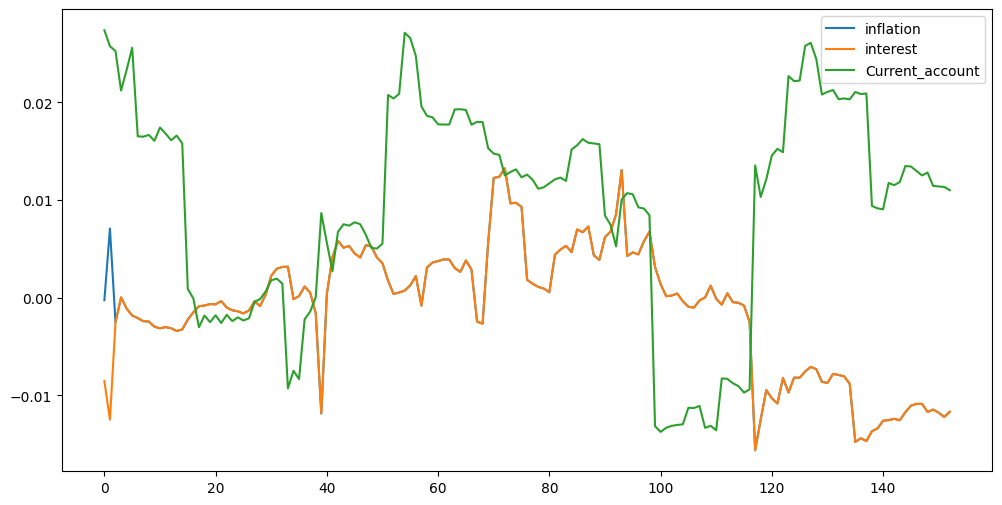

In [7]:
#rolling betas for the train set 
import statsmodels.api as sm

window = 36

train_betas = []

X = train_factors
Y = train_target

for start in range(len(X)-window+1):
    end = start + window
    X_window = X.iloc[start:end]
    Y_window = Y.iloc[start:end]
    X_window = sm.add_constant(X_window)
    model = sm.OLS(Y_window, X_window).fit()
    train_betas.append(model.params)

train_betas = np.array(train_betas)

plt.figure(figsize=(12, 6))
plt.plot(train_betas[:,1], label ='inflation')
plt.plot(train_betas[:,2], label = 'interest')
plt.plot(train_betas[:,3], label = 'Current_account')

plt.legend()
plt.show()

In [8]:
train_target

0      0.000000
1     -0.001613
2      0.003867
3      0.010117
4      0.009262
         ...   
183    0.023279
184   -0.017255
185    0.004731
186    0.013187
187   -0.005426
Name: USDINR_20Y, Length: 188, dtype: float64

In [9]:
tr_betas_df = pd.DataFrame(train_betas, columns=['const', 'inflation', 'interest', 'Current_account'])

In [10]:
train_dates = pd.DataFrame(train_dates, columns=['month-year'])

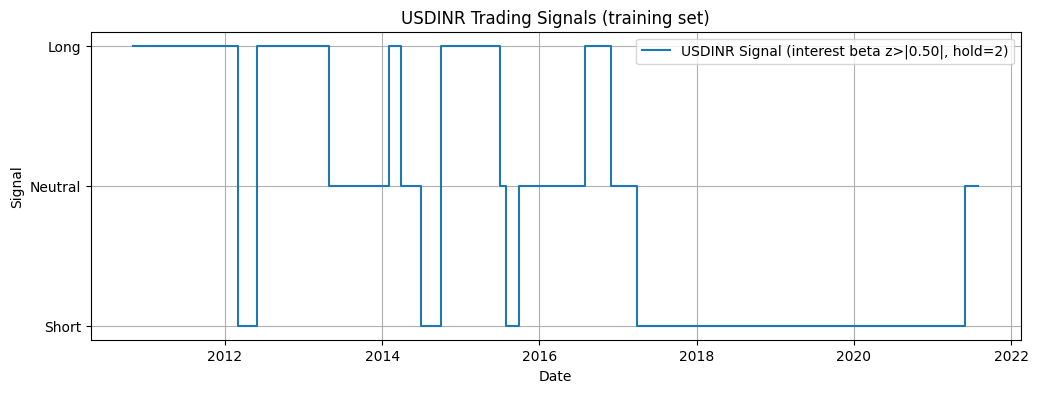

Best z: 0.5
            interest
month-year          
2021-06-01 -0.011778
2021-07-01 -0.012218
2021-08-01 -0.011682
        date  signal
0 2021-04-01      -1
1 2021-05-01      -1
2 2021-06-01       0
3 2021-07-01       0
4 2021-08-01       0


In [11]:
# ...existing code...
# USDCHF training signals from rolling interest beta

# 0) Preconditions: train_betas (rolling OLS params over window) already computed, and
#                   train_target (with ['USDCHF_20Y','month-year']) and `window` exist.

# 1) Align window-end dates for the betas

dates_train = pd.to_datetime(train_dates['month-year'] if isinstance(train_dates, pd.DataFrame) else train_dates)
assert len(dates_train) >= window, "Not enough rows for the chosen rolling window."



# If you created a DataFrame of params, prefer named columns to avoid mislabeling
if 'tr_betas_df' in globals():
    betas = tr_betas_df.copy()
else:
    betas = pd.DataFrame(train_betas, columns=['const','inflation','interest','Current_account'])

betas.index = dates_train[window-1:]  # align to window end

# 2) Take the interest beta series
interest_beta_train = betas['interest'].astype(float)

# 3) Smooth and standardize
beta_smooth = interest_beta_train.ewm(span=6, adjust=False).mean()
beta_z = (beta_smooth - beta_smooth.rolling(24).mean()) / (beta_smooth.rolling(24).std() + 1e-8)
beta_z = beta_z.dropna()

# 4) Build USDCHF train returns, align, and use next-period return (no look-ahead)
ret_train = train_target
ret_aligned = ret_train.reindex(beta_z.index)
ret_fwd = ret_aligned.shift(-1)  # t -> t+1 return

# 5) Pick a z-threshold on a calibration split inside train
z_grid = np.arange(0.5, 1.6, 0.25)
split = int(len(beta_z) * 0.7)
beta_cal, beta_val = beta_z.iloc[:split], beta_z.iloc[split:]
ret_cal, ret_val = ret_fwd.iloc[:split], ret_fwd.iloc[split:]

def sharpe_for(z):
    sig = np.sign(beta_cal.where(beta_cal.abs() >= z, 0)).astype(int)
    strat = (sig * ret_cal).dropna()
    return float(strat.mean() / (strat.std(ddof=0) + 1e-12))

best_z = max(z_grid, key=sharpe_for)

# 6) Final signals with a minimum holding period to reduce churn
raw_sig = np.sign(beta_z.where(beta_z.abs() >= best_z, 0)).astype(int)
min_hold = 2  # months
sig = raw_sig.replace(0, np.nan).ffill(limit=min_hold-1).fillna(0).astype(int)

usdchf_train_signals = sig.values
usdchf_train_signal_dates = sig.index.values

# 7) Plot
plt.figure(figsize=(12, 4))
plt.plot(usdchf_train_signal_dates, usdchf_train_signals, drawstyle='steps-post',
         label=f'USDINR Signal (interest beta z>|{best_z:.2f}|, hold={min_hold})')
plt.title('USDINR Trading Signals (training set)')
plt.xlabel('Date'); plt.ylabel('Signal'); plt.yticks([-1,0,1], ['Short','Neutral','Long'])
plt.legend(); plt.grid(True); plt.show()

# 8) Quick diagnostics
print("Best z:", best_z)
print(betas[['interest']].tail(3))
print(pd.DataFrame({'date': usdchf_train_signal_dates[-5:], 'signal': usdchf_train_signals[-5:]}))
# ...existing code...

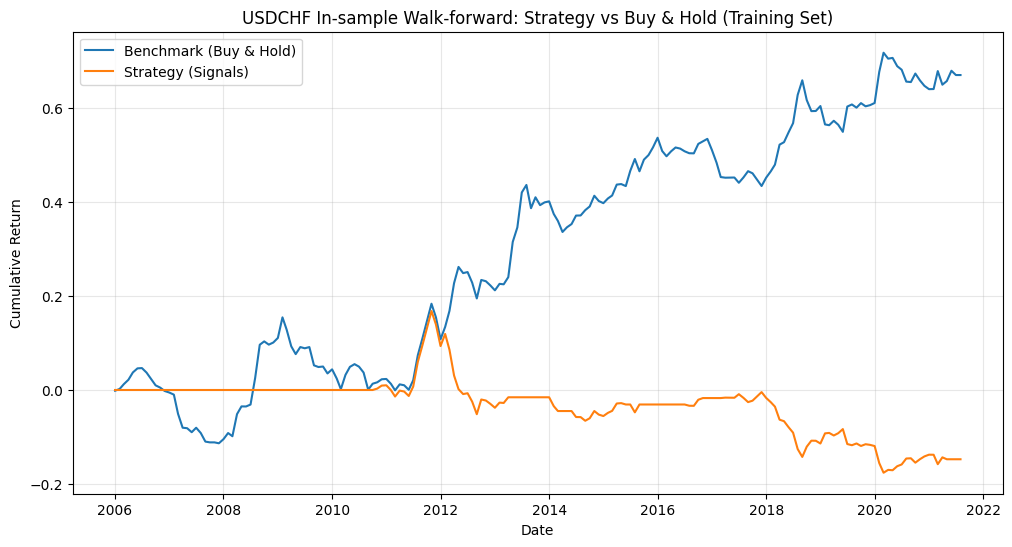

Train total return (strategy): -0.14727170781774857
Train total return (benchmark): 0.6697485287068845
Train Sharpe (strategy): -0.2132676957082946
Train Sharpe (benchmark): 0.5409160563676828
Train hit rate (strategy): 0.2393617021276596
Avg turnover per period: 0.0797872340425532
          date   ret_fwd  signal  strat_ret  cum_strat  cum_bench
178 2020-11-01 -0.008740      -1   0.008740  -0.147144   0.658297
179 2020-12-01 -0.006934      -1   0.006934  -0.141230   0.646799
180 2021-01-01 -0.004299      -1   0.004299  -0.137538   0.639719
181 2021-02-01  0.000162      -1  -0.000162  -0.137678   0.639985
182 2021-03-01  0.023279      -1  -0.023279  -0.157752   0.678161
183 2021-04-01 -0.017255      -1   0.017255  -0.143218   0.649204
184 2021-05-01  0.004731      -1  -0.004731  -0.147272   0.657007
185 2021-06-01  0.013187       0   0.000000  -0.147272   0.678858
186 2021-07-01 -0.005426       0  -0.000000  -0.147272   0.669749
187 2021-08-01  0.000000       0   0.000000  -0.147272   

In [12]:
# In-sample walk-forward test (training set) for USDCHF vs Buy & Hold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build full training date index and returns (no look-ahead: use next-period returns)
dates_train_full = pd.to_datetime(train_dates['month-year'].values)
ret_train = train_target
ret_fwd_train = ret_train.shift(-1).fillna(0.0)  # t -> t+1

# 2) Align signals to full training dates; neutral (0) when signal missing
sig_series = pd.Series(usdchf_train_signals, index=pd.to_datetime(usdchf_train_signal_dates))
sig_full_train = sig_series.reindex(dates_train_full).fillna(0).astype(int)

# 3) Strategy and benchmark returns
strategy_returns_train = sig_full_train.values * ret_fwd_train.values
benchmark_returns_train = ret_fwd_train.values  # buy & hold

# 4) Cumulative (compounded) performance
cum_strat = np.cumprod(1.0 + strategy_returns_train) - 1.0
cum_bench = np.cumprod(1.0 + benchmark_returns_train) - 1.0

# 5) Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(dates_train_full, cum_bench, label='Benchmark (Buy & Hold)')
plt.plot(dates_train_full, cum_strat, label='Strategy (Signals)')
plt.title('USDCHF In-sample Walk-forward: Strategy vs Buy & Hold (Training Set)')
plt.xlabel('Date'); plt.ylabel('Cumulative Return'); plt.grid(True, alpha=0.3); plt.legend()
plt.show()

# 6) Summary stats
def sharpe_annualized(x):
    x = np.asarray(x)
    return float(np.mean(x) / (np.std(x) + 1e-12) * np.sqrt(12))

hit_rate = float(np.mean(strategy_returns_train > 0))
turnover = float(np.mean(np.abs(np.diff(sig_full_train.values, prepend=0)) > 0))

print('Train total return (strategy):', float(cum_strat[-1]))
print('Train total return (benchmark):', float(cum_bench[-1]))
print('Train Sharpe (strategy):', sharpe_annualized(strategy_returns_train))
print('Train Sharpe (benchmark):', sharpe_annualized(benchmark_returns_train))
print('Train hit rate (strategy):', hit_rate)
print('Avg turnover per period:', turnover)

# Inspect last few rows
out = pd.DataFrame({
    'date': dates_train_full,
    'ret_fwd': ret_fwd_train.values,
    'signal': sig_full_train.values,
    'strat_ret': strategy_returns_train,
    'cum_strat': cum_strat,
    'cum_bench': cum_bench,
})
print(out.tail(10))

In [13]:
# ...existing code...
# USDCHF: out-of-sample test signals and forward test vs Buy & Hold

import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preconditions: train_factors, test_factors, train_target, test_target, window, best_z, min_hold exist
assert 'best_z' in globals(), "Run the training-signal cell first to set best_z."
assert 'min_hold' in globals(), "Run the training-signal cell first to set min_hold."
assert len(train_factors) >= window, "Train length must be >= rolling window."

# 1) Concatenate factors/target to roll forward through test using only past data
X_all = pd.concat([train_factors, test_factors], axis=0).reset_index(drop=True)
Y_all = pd.concat([train_target['USDINR_20Y'], test_target['USDINR_20Y']], axis=0).reset_index(drop=True)
dates_all = pd.to_datetime(pd.concat([train_target['month-year'], test_target['month-year']], axis=0).reset_index(drop=True))

test_start = len(train_factors)

# 2) Rolling OLS betas for test dates (window ends at each test date)
test_params = []
test_param_dates = []
for i in range(test_start, len(X_all)):
    start = i - window + 1
    if start < 0:
        continue
    X_win = sm.add_constant(X_all.iloc[start:i+1])
    Y_win = Y_all.iloc[start:i+1]
    res = sm.OLS(Y_win, X_win).fit()
    test_params.append(res.params)         # named Series: ['const','Inflation','Interest_Rate_Diff','Current_Account_Diff']
    test_param_dates.append(dates_all.iloc[i])

test_betas_df = pd.DataFrame(test_params)
test_betas_df.index = pd.to_datetime(test_param_dates)

# 3) Select the interest beta, smooth, and standardize (using only past test info)
interest_col = 'Interest_Rate_Diff' if 'Interest_Rate_Diff' in test_betas_df.columns else 'interest'
interest_beta_test = test_betas_df[interest_col].astype(float)

beta_smooth_test = interest_beta_test.ewm(span=6, adjust=False).mean()
beta_z_test = (beta_smooth_test - beta_smooth_test.rolling(24).mean()) / (beta_smooth_test.rolling(24).std() + 1e-12)
beta_z_test = beta_z_test.dropna()

# 4) Apply frozen train parameters to form test signals
raw_sig_test = np.sign(beta_z_test.where(beta_z_test.abs() >= best_z, 0)).astype(int)
sig_test = raw_sig_test.replace(0, np.nan).ffill(limit=min_hold-1).fillna(0).astype(int)

usdchf_test_signals = sig_test.values
usdchf_test_signal_dates = sig_test.index.values

# 5) Build test forward returns and evaluate vs Buy & Hold (out-of-sample)
test_dates_full = pd.to_datetime(test_target['month-year'].values)
ret_test = pd.Series(test_target['USDINR_20Y'].pct_change().fillna(0.0).values, index=test_dates_full)
ret_fwd_test = ret_test.shift(-1).fillna(0.0)

sig_full_test = pd.Series(usdchf_test_signals, index=pd.to_datetime(usdchf_test_signal_dates)) \
                    .reindex(test_dates_full).fillna(0).astype(int)

strategy_returns_test = sig_full_test.values * ret_fwd_test.values
benchmark_returns_test = ret_fwd_test.values

# 6) Plot cumulative performance
cum_strat_test = np.cumprod(1.0 + strategy_returns_test) - 1.0
cum_bench_test = np.cumprod(1.0 + benchmark_returns_test) - 1.0

plt.figure(figsize=(12, 6))
plt.plot(test_dates_full, cum_bench_test, label='Benchmark (Buy & Hold)')
plt.plot(test_dates_full, cum_strat_test, label='Strategy (Signals)')
plt.title('USDINR Out-of-sample Forward Test (Test Set)')
plt.xlabel('Date'); plt.ylabel('Cumulative Return'); plt.grid(True, alpha=0.3); plt.legend()
plt.show()

# 7) Summary stats
def sharpe_annualized(x):
    x = np.asarray(x)
    return float(np.mean(x) / (np.std(x) + 1e-12) * np.sqrt(12))

hit_rate = float(np.mean(strategy_returns_test > 0))
turnover = float(np.mean(np.abs(np.diff(sig_full_test.values, prepend=0)) > 0))

print('Test total return (strategy):', float(cum_strat_test[-1]))
print('Test total return (benchmark):', float(cum_bench_test[-1]))
print('Test Sharpe (strategy):', sharpe_annualized(strategy_returns_test))
print('Test Sharpe (benchmark):', sharpe_annualized(benchmark_returns_test))
print('Test hit rate (strategy):', hit_rate)
print('Avg turnover per period (test):', turnover)

# Inspect last few rows
out_test = pd.DataFrame({
    'date': test_dates_full,
    'ret_fwd': ret_fwd_test.values,
    'signal': sig_full_test.values,
    'strat_ret': strategy_returns_test,
    'cum_strat': cum_strat_test,
    'cum_bench': cum_bench_test,
})
print(out_test.tail(10))
# ...existing code...

KeyError: 'USDINR_20Y'

from USDJPY implementation, X = imp 3 (differencing) ? Y = pct change differencing
